In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import math
import time
import random
import datetime
import json
from tensorboard import notebook
from sklearn.model_selection import KFold, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import dlib
import glob
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Concatenate, Dropout, Activation, Add, Input, Dense, Conv2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D, MaxPooling2D, AvgPool2D, Flatten
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
#from monitor_training import MonitorSingleTraining
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from multiprocessing import Queue
import pandas as pd
import scikitplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score

In [2]:
img_path = "../input/ckplus/CK+48"
num_classes = 7
#global total_images = 0
filename_list=["anger", "contempt","disgust", "fear","happy", "sadness", "surprise"]
y_train=[]

In [3]:
# class label dictionaries
CLASS_LABEL_MAP = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Neutral", 5:"Sad", 6:"Surprise"}
LABEL_CLASS_MAP = {"Angry":0, "Disgust":1, "Fear":2, "Happy":3, "Neutral":4, "Sad":5, "Surprise":6}

In [4]:

def load_images(filename_list, width =300, height =300, org_dim=False):
    img_array = []
    
    for i in range(len(filename_list)):
        path=os.path.join(img_path,filename_list[i])
        class_num= filename_list[i]
        if org_dim == True:
            for img in os.listdir(path):
                im = load_img(path=os.path.join(path,img), color_mode="grayscale")
                im = np.array(im)
                im = np.repeat(im[...,np.newaxis],3,-1).reshape((im.shape[0],im.shape[1],3))
                total_images +=1
        else:  
            for img in os.listdir(path):
                #im = load_img(os.path.join(path,img), color_mode="grayscale")
                #im = np.array(im)
                #im = np.repeat(im[...,np.newaxis],3,-1).reshape((im.shape[0],im.shape[1],3))
                im = load_img(path=os.path.join(path,img),target_size=(width,height), color_mode="grayscale")
                im = np.repeat(np.array(im)[...,np.newaxis],3,-1).reshape((width,height,3))
                img_array.append(im)
                #y_train.append(class_num)
                #total_images +=1
        
    return np.array(img_array)

In [5]:
def CLAHE(img,clahe, verbose=False):
    
    equr = clahe.apply(img[:,:,0])
    equg = clahe.apply(img[:,:,1])
    equb = clahe.apply(img[:,:,2])
    equ = np.dstack((equr,equg,equb))
    
    if verbose==True:
        equ_minmax = cv2.normalize(equ, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        for i in range(0,28709):
            img[i] = img[i]/255.0
        for i in range(0,28709):
            equ[i] = equ[i]/255.0    
        plt.imshow(np.hstack((img,equ,equ_minmax)))
        plt.show()
        
    return equ


In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [7]:
def normalize_data(img_data,params={},verbose=False):
    
    normalized_img_data = []
    # contrast limited adaptive histogram equalization
    clahe_transform = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for i in range(img_data.shape[0]):
        normalized_img_data.append(CLAHE(np.array(img_data[i]),clahe_transform,verbose))
        
    normalized_img_data = np.array(normalized_img_data,dtype=np.float32)
    
    return normalized_img_data

In [8]:
img_array_300=load_images(filename_list,300,300)

In [9]:
img_array_300.shape

(981, 300, 300, 3)

In [10]:
normalized_img_array_300 = normalize_data(img_array_300)

In [11]:
normalized_img_array_300.shape

(981, 300, 300, 3)

In [12]:
opencv_dnn_caffe_model = "../input/modelcaffe/deploy.caffemodel"
opencv_dnn_caffe_prototxt = "../input/modelcaffe/deploy.prototxt.txt"
caffe_net = cv2.dnn.readNetFromCaffe(opencv_dnn_caffe_prototxt, opencv_dnn_caffe_model)

In [13]:
def face_crop(img_data):
    face_crop_img_data = []
    for i in range(img_data.shape[0]):
        image1=img_data[i]
        image2=img_data[i]
#         print(image1.shape)
        blob = cv2.dnn.blobFromImage(np.float32(image1), 1.0,(300, 300), (104.0, 117.0, 123.0))
        caffe_net.setInput(blob)
        faces = caffe_net.forward()
        w=300
        h=300  
        for j in range(0, faces.shape[2]):
            box = faces[0, 0, j, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            confidence = faces[0, 0, j, 2]
            if startX>300 or startY>300 or endX>300 or endY>300:
                continue
            if endX<startX or endY<startY:
                continue
              # If confidence > 0.5, show box around face
            flag=False
            if (confidence > 0.5):
                image3 = image1[startY:endY, startX:endX]
                #image1=cv2.resize(image1,(300,300))
                if(image3.shape[0]==0 or image3.shape[1]==0):
                    continue
                #print(image3.shape)
                face_crop_img_data.append(image3)
                flag=True
                break
        if(flag==False):
            face_crop_img_data.append(image2)
    #face_crop_img_data = np.array(face_crop_img_data,dtype=np.uint16)
    
    return face_crop_img_data

In [14]:
face_crop_img_data_300 = face_crop(normalized_img_array_300)

In [15]:
len(face_crop_img_data_300)

981

In [16]:
face_crop_img_data_300 = np.array(face_crop_img_data_300)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [17]:
face_crop=[]
for i in range(face_crop_img_data_300.shape[0]):
    image1=face_crop_img_data_300[i]
    image1=cv2.resize(image1,(224,224))
    face_crop.append(image1)

In [18]:
face_crop_array=np.array(face_crop)

In [19]:
face_crop_array.shape

(981, 224, 224, 3)

In [20]:
face_crop_array = face_crop_array/255.0

## input shuffle and data split

In [21]:
y_train = np.ones((981,),dtype='int64')

y_train[0:134]=0 #135
y_train[135:188]=1 #54
y_train[189:365]=2 #177
y_train[366:440]=3 #75
y_train[441:647]=4 #207
y_train[648:731]=5 #84
y_train[732:980]=6 #249

In [22]:
Y_train = to_categorical(y_train, 7)

In [23]:
#Shuffle the dataset
x,y = shuffle(face_crop_array,Y_train, random_state=2)

In [24]:
X_train, X_test, Y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)

In [25]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = Y_train.shape[1]

In [29]:
classifier_resnet = ResNet50(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = None,
    classes = num_classes
)

2022-03-26 12:03:00.602852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 12:03:00.638058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 12:03:00.638965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 12:03:00.640706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
for layer in classifier_resnet.layers:
    layer.trainable = True

In [31]:
classifier1 = classifier_resnet.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
#classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=7, activation='softmax')(classifier1)

model = Model(inputs = classifier_resnet.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [33]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [34]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [35]:
batch_size = 25
epochs = 40
#print("111111111111111111111111111111")
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]
#print("222222222222222222222222222222")
model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)
#print("333333333333333333333333333333")
history = model.fit_generator(
    train_datagen.flow(X_train, Y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-26 12:03:54.463105: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-03-26 12:04:01.007254: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 23s 331ms/step - loss: 93.5083 - accuracy: 0.1921 - val_loss: 163637767438336.0000 - val_accuracy: 0.2297
Epoch 2/40
33/33 [==============================] - 12s 347ms/step - loss: 33.5623 - accuracy: 0.1945 - val_loss: 265952821248.0000 - val_accuracy: 0.2635
Epoch 3/40
33/33 [==============================] - 11s 331ms/step - loss: 33.1124 - accuracy: 0.1729 - val_loss: 2245144576.0000 - val_accuracy: 0.3176
Epoch 4/40
33/33 [==============================] - 14s 397ms/step - loss: 26.1988 - accuracy: 0.2281 - val_loss: 9428369.0000 - val_accuracy: 0.2095
Epoch 5/40
33/33 [==============================] - 14s 391ms/step - loss: 21.7896 - accuracy: 0.2269 - val_loss: 134449.1562 - val_accuracy: 0.1892
Epoch 6/40
33/33 [==============================] - 13s 374ms/step - loss: 13.7452 - accuracy: 0.2365 - val_loss: 14458.6113 - val_accuracy: 0.1892
Epoch 7/40
33/33 [==============================] - 14s 407ms/step - loss: 14.4458 - accuracy: 0.2

In [36]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 1.5307940244674683
Test accuracy: 0.45270270109176636


In [37]:
model.save("Random_model_resnet224.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


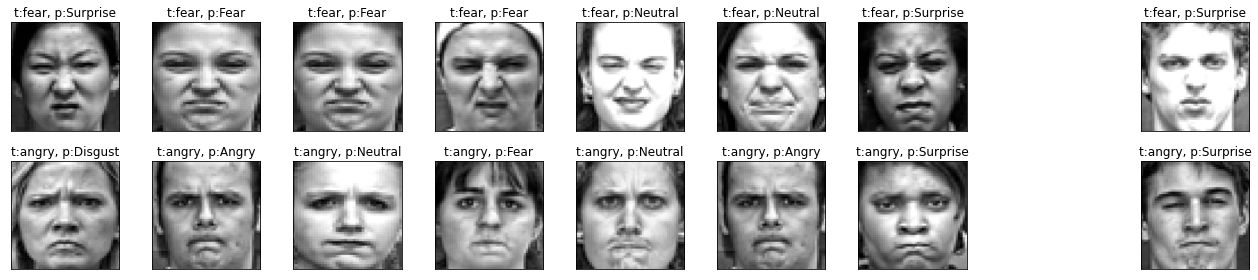

In [38]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, LABEL_CLASS_MAP["Fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, LABEL_CLASS_MAP["Angry"]]==1)[0], size=9, replace=False)

fig = plt.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = CLASS_LABEL_MAP[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = CLASS_LABEL_MAP[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        plt.tight_layout()


In [39]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

In [40]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==LABEL_CLASS_MAP[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==LABEL_CLASS_MAP[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = plt.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = CLASS_LABEL_MAP[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")

total 10 miss labels out of 10 for emotion Happy


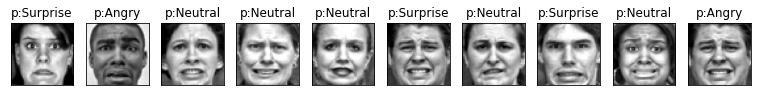

In [41]:
plot_miss_classified(emotion="Happy")

total 25 miss labels out of 32 for emotion Fear


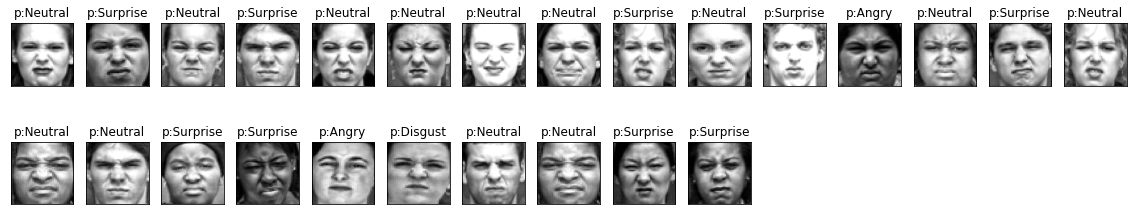

In [42]:
plot_miss_classified(emotion="Fear")

total 16 miss labels out of 20 for emotion Angry


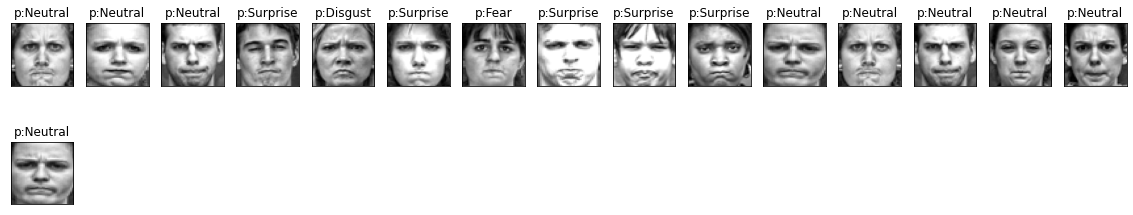

In [43]:
plot_miss_classified(emotion="Angry")

total 13 miss labels out of 23 for emotion Neutral


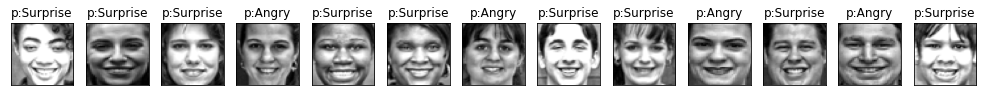

In [44]:
plot_miss_classified(emotion="Neutral")

total 4 miss labels out of 7 for emotion Disgust


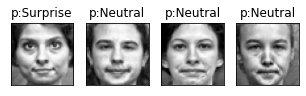

In [45]:
plot_miss_classified(emotion="Disgust")

total 4 miss labels out of 47 for emotion Surprise


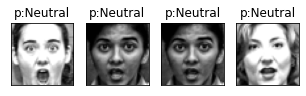

In [46]:
plot_miss_classified(emotion="Surprise")

total 9 miss labels out of 9 for emotion Sad


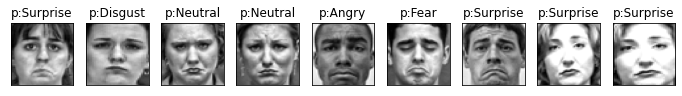

In [47]:
plot_miss_classified(emotion="Sad")

In [48]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [49]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [50]:
KERAS_MODEL_NAME = "Random_model_resnet224.h5"

In [51]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 278.555 Megabytes


In [52]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [53]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

2022-03-26 12:16:51.360379: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-03-26 12:17:09.230883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 12:17:09.231279: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-03-26 12:17:09.231410: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-03-26 12:17:09.232013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

In [54]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

48433904

In [55]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")

File size: 46.19 Megabytes


# Check Input Tensor Shape

In [56]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 7]
Output Type: <class 'numpy.float32'>


In [57]:
interpreter.resize_tensor_input(input_details[0]['index'], (148, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (148, 7))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [148 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [148   7]
Output Type: <class 'numpy.float32'>


In [58]:
X_test.dtype

dtype('float32')

In [59]:
interpreter.set_tensor(input_details[0]['index'], X_test)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (148, 7)


In [60]:
prediction_classes

array([4, 2, 6, 6, 4, 2, 6, 6, 4, 6, 4, 6, 6, 6, 6, 6, 6, 4, 6, 4, 4, 6,
       6, 4, 4, 4, 4, 4, 1, 6, 4, 4, 6, 0, 0, 6, 4, 4, 4, 4, 0, 6, 6, 6,
       6, 0, 6, 6, 6, 6, 6, 6, 6, 0, 1, 6, 1, 6, 6, 4, 4, 6, 4, 6, 0, 4,
       2, 6, 4, 4, 2, 6, 4, 6, 6, 2, 4, 6, 4, 6, 4, 4, 6, 2, 6, 6, 6, 6,
       6, 6, 6, 6, 0, 6, 6, 0, 6, 4, 6, 1, 6, 6, 4, 6, 4, 4, 4, 4, 4, 0,
       6, 6, 2, 4, 6, 6, 4, 0, 4, 6, 4, 6, 2, 0, 4, 6, 6, 6, 1, 6, 4, 4,
       4, 0, 6, 4, 6, 6, 4, 6, 6, 6, 1, 0, 6, 6, 6, 2])

In [61]:
Y_test_final = to_categorical(prediction_classes, 7)

In [62]:
acc = accuracy_score(Y_test_final, y_test)

In [63]:
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.4527027027027027
